In [2]:
from __future__ import division
import theano
import theano.tensor as T
import theano.tensor.signal.conv
import numpy as np
import cv2, scipy, time, os
from tqdm import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from my_utils import Progbar
from skimage import measure
import matlab_wrapper

In [6]:
###################
#### required functions
###################
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

## for computing loss of one step
def onepari(grayv_i, l_i, a_i, b_i, R_i, G_i, B_i, x_i, y_i, n_i, grayv, l, a, b, R, G, B, x, y, n, width, height, alpha, beta, gamma):
    ## non-linearity of the color contrast
    l_delta = alpha[0]*(l_i - l)
    a_delta = alpha[1]*(a_i - a)
    b_delta = alpha[2]*(b_i - b)
#     s_delta = (alpha[0] * T.abs_(l_delta) + alpha[1] * T.abs_(a_delta) + alpha[2]*T.abs_(b_delta))/(sum(alpha))
    s_delta = T.sqrt(T.sqr(l_delta) + T.sqr(a_delta) + T.sqr(b_delta)) # here can be nonlinearity, can separate l,a,b channels

    ## non-linearity of gray_delta 
#     g_delta = 1 / np.log(1/beta + 1) / (grayv + beta) * (grayv_i - grayv)
    g_delta = beta / (grayv + beta) * (grayv_i - grayv) # beta controls the nonlinearity of grayv
#     g_delta = grayv_i - grayv

    ## assign sign flag to the g_delta
    R_delta = R_i - R
    G_delta = G_i - G
    B_delta = B_i - B  
    flag = 1 * T.and_(T.and_(T.gt(R_delta, 0),T.gt(G_delta,0)),T.gt(B_delta,0)) + (-1)*T.and_(T.and_(T.lt(R_delta, 0),T.lt(G_delta,0)),T.lt(B_delta,0))  
    g_delta_flag = T.switch(T.eq(flag, 0), T.abs_(g_delta), flag*g_delta)

    ## non-linearity of the region importance weight
    w_i = n_i * n / T.sqr(0.01 * width * height)
#     w_i = T.log(n_i * n / T.sqr(0.01 * n_sum)) # nonlinear version of the weight
#     w_i = w_i * T.gt(w_i,0)
    
    ## the non-linear distance weight
    dist = gamma * (T.sqr(x_i - x) + T.sqr(y_i - y))
    diag = (T.sqr(width) + T.sqr(height))
    w_dist = T.exp(-dist/diag)
    
    ## final contrast loss
#     loss =T.sum(w_dist * w_i * T.sqr(g_delta_flag - s_delta))    
    loss =T.sum(w_dist * w_i * T.sqr(g_delta_flag - s_delta))    

    return loss

## build up the loss function
def buildloss(alpha,beta,gamma):
    w = []
    for i in range(9):
        if i < 3:
            w.append(theano.shared(floatX(1/3)))
        else:
            w.append(theano.shared(floatX(0)))
    lr = theano.shared(floatX(0.01))
    
    R = T.fvector('R')
    G = T.fvector('G')
    B = T.fvector('B')
    l = T.fvector('l')
    a = T.fvector('a')
    b = T.fvector('b')
    x = T.fvector('x')
    y = T.fvector('y')
    n = T.fvector('n')
    width = T.fscalar('width')
    height = T.fscalar('height')
 
    grayv = w[0] * R + w[1] * G + w[2]*B + w[3] *R*G + w[4]*G*B + w[5]*B*R + w[6]*(T.sqr(R)) + w[7]*(T.sqr(G)) +w[8]*(T.sqr(B)) 
    
    loss_c, updates = theano.scan(fn=onepari,
                                  outputs_info=None,
                                  sequences=[grayv, l, a, b, R, G, B, x, y, n],
                                  non_sequences=[grayv, l, a, b, R, G, B, x, y, n, width, height, alpha, beta, gamma])
    
    loss_contrast = T.sum(loss_c)/2
    loss_contrast = loss_contrast 
#     loss_contrast = loss_contrast + T.sum(1e5 * T.gt(grayv,1)*(grayv-1) + 1e5 * T.lt(grayv,0)*(0 - grayv))
    
    w_update, m_previous, v_previous, t = Adam(loss_contrast,w,learning_rate=lr)
    outputs = []
    outputs.append(loss_contrast)
    
    func = theano.function([R,G,B,l,a,b,x,y,n,width,height],outputs=outputs,updates=w_update)
    return func,w,lr,m_previous,v_previous, t

def Adam(loss, all_params, learning_rate=0.001, b1=0.9, b2=0.999, e=1e-8,
         gamma=1-1e-8):
    """
    ADAM update rules
    Default values are taken from [Kingma2014]
    References:
    [Kingma2014] Kingma, Diederik, and Jimmy Ba.
    "Adam: A Method for Stochastic Optimization."
    arXiv preprint arXiv:1412.6980 (2014).
    http://arxiv.org/pdf/1412.6980v4.pdf
    """
    updates = []
    all_grads = theano.grad(loss, all_params)
    alpha = learning_rate
    t = theano.shared(np.float32(1))
    b1_t = b1*gamma**(t-1)   #(Decay the first moment running average coefficient)
    
    m_previous_v = []
    v_previous_v = []
    for theta_previous, g in zip(all_params, all_grads):
        m_previous = theano.shared(np.zeros(theta_previous.get_value().shape,
                                            dtype=theano.config.floatX))
        v_previous = theano.shared(np.zeros(theta_previous.get_value().shape,
                                            dtype=theano.config.floatX))

        m = b1_t*m_previous + (1 - b1_t)*g                             # (Update biased first moment estimate)
        v = b2*v_previous + (1 - b2)*g**2                              # (Update biased second raw moment estimate)
        m_hat = m / (1-b1**t)                                          # (Compute bias-corrected first moment estimate)
        v_hat = v / (1-b2**t)                                          # (Compute bias-corrected second raw moment estimate)
        theta = theta_previous - (alpha * m_hat) / (T.sqrt(v_hat) + e) #(Update parameters)

        updates.append((m_previous, m))
        updates.append((v_previous, v))
        updates.append((theta_previous, theta) )
        
        m_previous_v.append(m_previous)
        v_previous_v.append(v_previous)
    updates.append((t, t + 1.))
    return updates, m_previous_v,v_previous_v,t
        

In [7]:
def color2gray(path_images, img_name,lr_init=1,n_iter=1000):
    
    ## load the images
    img = cv2.imread(path_images + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    R_img = img[:,:,0].astype(np.float32) / 255
    G_img = img[:,:,1].astype(np.float32) / 255
    B_img = img[:,:,2].astype(np.float32) /255

    l_img = (lab_img[:,:,0]).astype(np.float32) / 255 
    a_img = (lab_img[:,:,1]).astype(np.float32) / 255
    b_img = (lab_img[:,:,2]).astype(np.float32) / 255

    sz = img.shape
    n_p = sz[0] * sz[1]
#     print sz, n_p
    
    ## automatically determine the numner of clusters
    matlab.put('filename', path_images + img_name)
    matlab.put('cdist', 30)
    matlab.put('minsize', 20)
    matlab.eval('findkmeans')
    numklabels = matlab.get('numklabels')
    klabels = matlab.get('klabels')
    numclabels = matlab.get('numclabels')
    clabels = matlab.get('clabels')
#     print 'number of k clusters: ', numklabels
#     print 'number of c clusters: ', numclabels
#     klabels = clabels
#     numklabels = numclabels
    
    ## build the statistics 
    grid = np.indices((sz[0], sz[1]),dtype=np.float32)
    xgrid = grid[0]
    ygrid = grid[1]
    n_pixels = np.zeros((numklabels,)).astype(np.float32)
    R_ini = np.zeros((numklabels,)).astype(np.float32)
    G_ini = np.zeros((numklabels,)).astype(np.float32)
    B_ini = np.zeros((numklabels,)).astype(np.float32)
    l_ini = np.zeros((numklabels,)).astype(np.float32)
    a_ini = np.zeros((numklabels,)).astype(np.float32)
    b_ini = np.zeros((numklabels,)).astype(np.float32)
    x_ini = np.zeros((numklabels,)).astype(np.float32)
    y_ini = np.zeros((numklabels,)).astype(np.float32)

    for i in range(numklabels):
        n_pixels[i] = np.sum(klabels==i)
        R_ini[i] = np.sum(R_img * (klabels == i))/n_pixels[i]
        G_ini[i] = np.sum(G_img * (klabels == i))/n_pixels[i]
        B_ini[i] = np.sum(B_img * (klabels == i))/n_pixels[i]

        l_ini[i] = np.sum(l_img * (klabels == i))/n_pixels[i]
        a_ini[i] = np.sum(a_img * (klabels == i))/n_pixels[i]
        b_ini[i] = np.sum(b_img * (klabels == i))/n_pixels[i]
        
        x_ini[i] = np.sum(xgrid * (klabels == i))/n_pixels[i]
        y_ini[i] = np.sum(ygrid * (klabels == i))/n_pixels[i]
    # w_all = ((n_pixels.sum()**2 - n_pixels.dot(n_pixels)) / 2).astype(np.float32)

    ## compute the adjacency matrix between colors
    # w_ij = np.zeros((numklabels,numklabels)).astype(np.float32)
    # for i in range(sz[0]-1):
    #     for j in range(sz[1]-1):
    #         w_ij[klabels[i,j],klabels[i+1,j]] = w_ij[klabels[i,j],klabels[i+1,j]] + 1
    #         w_ij[klabels[i,j],klabels[i,j+1]] = w_ij[klabels[i,j],klabels[i,j+1]] + 1
    # np.fill_diagonal(w_ij,0)
    # w_ij = w_ij + w_ij.T 
    # w_ij = (w_ij.T / np.sum(w_ij,axis=1)).T
    
    ## draw the clustering results
#     fig = plt.figure(figsize=(20, 4))
#     ax = fig.add_subplot(141)
#     ax.imshow(img)
#     ax.set_title('ori')
#     ax.axis('off')

#     ax = fig.add_subplot(142)
#     ax.imshow(klabels,cmap='gray')
#     ax.set_title('clusters')
#     ax.axis('off')
    
#     g_ini = np.copy(l_ini)
#     imgg_ini = draw_gray(klabels,g_ini,mask)

#     ax = fig.add_subplot(143)
#     ax.imshow(imgg_ini,cmap='gray')
#     ax.set_title('initial')
#     ax.axis('off')

#     imgc_ini = draw_color(klabels,img,mask)
#     ax = fig.add_subplot(144)
#     ax.imshow(imgc_ini.astype(np.uint8),vmin=0,vmax=255)
#     ax.set_title('initial')
#     ax.axis('off')

#     plt.show()
    
    ## perform the decolorization optimization
    #### initialize the parameters, the learning rate and the shared variable for Adam
    for i in range(9):
        if i < 3:
            w[i].set_value(floatX(1/3))
        else:
            w[i].set_value(floatX(0))
    wv = [i.get_value() for i in w]
#     print wv

    lr.set_value(lr_init)   
#     print lr.get_value()

    for i in range(9):
        m_previous[i].set_value(floatX(0))
        v_previous[i].set_value(floatX(0))
    t.set_value(floatX(1))
    m_previous_vtemp = [i.get_value() for i in m_previous]
    v_previous_vtemp = [i.get_value() for i in v_previous]
#     print m_previous_vtemp
#     print v_previous_vtemp
#     print t.get_value()
    
    ## perform the optimization
#     progbar = Progbar(n_iter,verbose=1)
    for i in range(n_iter):
        loss = func(R_ini,G_ini,B_ini,l_ini,a_ini,b_ini,x_ini,y_ini,n_pixels,sz[0],sz[1])
#         progbar.add(1., values=[("train loss", loss[0]),])
    
    wv = [i.get_value() for i in w]
#     print wv

    ## draw the decolorization results
    img_g =  wv[0] * R_img + wv[1] * G_img + wv[2]*B_img + wv[3] *R_img*G_img + wv[4]*G_img*B_img + wv[5]*B_img*R_img + wv[6]*(R_img**2) + wv[7]*(G_img**2) +wv[8]*(B_img**2)
    
    return img_g

In [8]:
def scan_parameters():
    for lr_init in [0.1,0.01,0.001,1]:
        for alpha in [[1,1,1],[2,1,1],[3,1,1],[1,2,2],[1,3,3]]:
            for beta in [2,1,0.5,0.1]:
                for gamma in [10,5,1,0.5,0.1]:
                    yield (lr_init,alpha,beta,gamma)

In [9]:
###########
## Build up the theano function and the matlab session
###########
func,w,lr,m_previous,v_previous, t = buildloss([2,1,1],2,0)
matlab = matlab_wrapper.MatlabSession()

In [575]:
## process all images in the folder
test_idx = '1'
# path_base = '/data/bjin/MyDecolor/dataset/Cadik/'
path_base = '/data/bjin/MyDecolor/dataset/CSDD_Dataset/'
path_images = path_base + 'images/'
path_results_CIEL = path_base + 'CIEL/'
path_results_mine = path_base + 'mine/test' + test_idx + '/'
path_results_2012Lu = path_base + '2012_Lu/'
path_results_2013Song = path_base + '2013_Song/'
path_results_2015Du = path_base + '2015_Du/'
path_results_2015Liu = path_base + '2015_Liu/'

lr_init = 0.0005
n_iter = 1000

if not os.path.isdir(path_results_mine):
    os.mkdir(path_results_mine)
files = os.listdir(path_images)
files.sort()
n_files = len(files)

for i in tqdm(range(n_files)):
    img_name = files[i]
    if img_name[0] is '.':
        continue
#     print '************processing : ' + img_name + '************'
    
    try: 
        img_g = color2gray(path_images, img_name,lr_init=lr_init,n_iter=n_iter)
    except:
        matlab = matlab_wrapper.MatlabSession()
        img_g = color2gray(path_images, img_name,lr_init=lr_init,n_iter=n_iter)
    img_g = (img_g - np.min(img_g))/(np.max(img_g) - np.min(img_g))
    
    ## plot the respective results
#     fig = plt.figure(figsize=(20, 4))
    
#     ax = fig.add_subplot(161)
#     img = cv2.imread(path_images + img_name)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ax.imshow(img)
#     ax.set_title('ori')
#     ax.axis('off')

#     ax = fig.add_subplot(162)
#     img_2012Lu = cv2.imread(path_results_2012Lu + img_name)
#     ax.imshow(img_2012Lu,cmap='gray')
#     ax.set_title('2012 Lu')
#     ax.axis('off')

#     ax = fig.add_subplot(163)
#     img_2013Song = cv2.imread(path_results_2013Song + img_name)
#     ax.imshow(img_2013Song,cmap='gray')
#     ax.set_title('2013 Song')
#     ax.axis('off')

#     ax = fig.add_subplot(164)
#     img_2015Du = cv2.imread(path_results_2015Du + img_name)
#     ax.imshow(img_2015Du,cmap='gray')
#     ax.set_title('2015 Du')
#     ax.axis('off')
    
#     ax = fig.add_subplot(165)
# #     img_2015Liu = cv2.imread(path_results_2015Liu + img_name)
#     img_2015Liu = cv2.imread(path_results_CIEL + img_name)
#     ax.imshow(img_2015Liu,cmap='gray')
#     ax.set_title('CIEL')
#     ax.axis('off')
    
#     ax = fig.add_subplot(166)
#     ax.imshow(img_g,cmap='gray')
#     ax.set_title('mine')
#     ax.axis('off')
#     plt.show()
    
    cv2.imwrite(path_results_mine+img_name,(img_g*255).astype(np.uint8))


100%|██████████| 22/22 [04:56<00:00, 11.81s/it]


In [566]:
## evaluation 
matlab = matlab_wrapper.MatlabSession()

matlab.put('thrNum', 15)
matlab.put('imNum', 24)
matlab.put('path_base', path_base)
matlab.put('path_results_mine', path_results_mine)
matlab.eval('Computemetrics')
CCPR = matlab.get('CCPR')
CCFR = matlab.get('CCFR')
Escore = matlab.get('Escore')
print 'mine ' + '2012 Lu ' + '2013 Song ' + '2015 Du ' + '2015 Liu '
print CCPR

mine 2012 Lu 2013 Song 2015 Du 2015 Liu 
[[ 0.96687234  0.94424905  0.92637764  0.90814634  0.8927261   0.87810178
   0.86465649  0.85189774  0.84022119  0.82805622  0.81443342  0.79490558
   0.77745956  0.76415904  0.75002881]
 [ 0.96647499  0.943362    0.92438165  0.90832196  0.89240099  0.87600867
   0.86065135  0.84769524  0.83398591  0.82086553  0.80853186  0.79455791
   0.7800474   0.7683703   0.75632736]
 [ 0.96468308  0.94235473  0.92392849  0.90772873  0.89127698  0.87273702
   0.85701841  0.84313244  0.82787204  0.81122785  0.79577293  0.77901298
   0.7646607   0.75282297  0.73944256]
 [ 0.96653885  0.94655042  0.92779111  0.91395931  0.90373507  0.88964025
   0.87820621  0.86623599  0.85557556  0.84038493  0.82719286  0.81328721
   0.80215019  0.7912512   0.78017817]
 [ 0.96346652  0.94335057  0.92761983  0.91280393  0.89997155  0.88499926
   0.87381952  0.8636342   0.85289508  0.84064619  0.82995565  0.8191374
   0.80884081  0.79928789  0.78834464]]


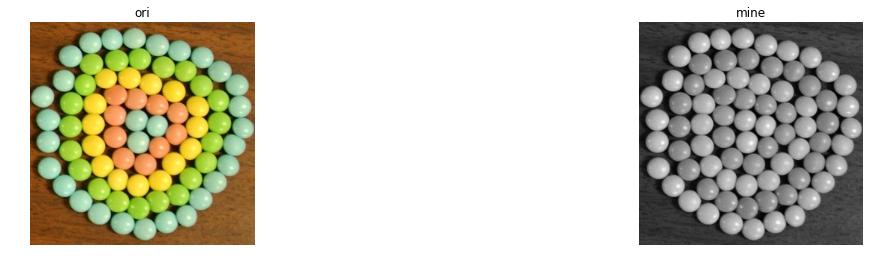

In [11]:
path_base = '/data/bjin/MyDecolor/dataset/CSDD_Dataset/'
path_images = path_base + 'images/'
img_name = '8.png'
img_g = color2gray(path_images, img_name,lr_init=0.0005,n_iter=2000)


fig = plt.figure(figsize=(20, 4))
    
ax = fig.add_subplot(121)
img = cv2.imread(path_images + img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax.imshow(img)
ax.set_title('ori')
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(img_g,cmap='gray')
ax.set_title('mine')
ax.axis('off')

plt.show()

In [377]:
###########
## Main functions 
###########
test_idx = '3'
path_base = '/data/bjin/MyDecolor/dataset/Cadik/'
path_images = path_base + 'images/'
path_results_mine = path_base + 'mine/test' + test_idx + '/'
path_results_2012Lu = path_base + '2012_Lu/'
path_results_2013Song = path_base + '2013_Song/'
path_results_2015Du = path_base + '2015_Du/'
path_results_2015Liu = path_base + '2015_Liu/'

lr_init = 0.1
n_iter = 1000

fptr = open(path_base + 'logs/Decolor_test' + test_idx + '.txt','w+')
print 'writing logs to ' + path_base + 'logs/Decolor_test' + test_idx

if not os.path.isdir(path_results_mine):
    os.mkdir(path_results_mine)
files = os.listdir(path_images)
files.sort()
n_files = len(files)

for (alpha,beta,gamma) in scan_parameters():
    print alpha, beta, gamma
    print >>fptr, '*'*20
    print >>fptr, alpha, beta

    func,w,lr,m_previous,v_previous,t = buildloss(alpha,beta,gamma)
    matlab = matlab_wrapper.MatlabSession()

    ## generate the gray scale images
    for img_name in files:
        if img_name[0] is '.':
            continue
        print '----------processing: ' + img_name + '---------'
        try: 
            img_g = color2gray(path_images, img_name,lr_init=lr_init,n_iter=n_iter)
        except:
            matlab = matlab_wrapper.MatlabSession()
            img_g = color2gray(path_images, img_name,lr_init=lr_init,n_iter=n_iter)
        img_g = (img_g - np.min(img_g))/(np.max(img_g) - np.min(img_g))
        cv2.imwrite(path_results_mine+img_name,(img_g*255).astype(np.uint8))

    ## evaluation
    matlab = matlab_wrapper.MatlabSession()

    matlab.put('thrNum', 15)
    matlab.put('imNum', 24)
    matlab.put('path_base', path_base)
    matlab.put('path_results_mine', path_results_mine)
    matlab.eval('Computemetrics')
    CCPR = matlab.get('CCPR')
    CCFR = matlab.get('CCFR')
    Escore = matlab.get('Escore')
    print 'mine ' + '2012 Lu ' + '2013 Song ' + '2015 Du ' + '2015 Liu '
    print CCPR
    print >>fptr, 'CCPR'
    print >>fptr, CCPR
    print >>fptr, 'CCFR'
    print >>fptr, CCFR
    print >>fptr, 'Escore'
    print >>fptr, Escore
    print >>fptr, '*'*20
    fptr.flush()
    os.fsync(fptr.fileno())

fptr.close()

writing logs to /data/bjin/MyDecolor/dataset/Cadik/logs/Decolor_test3
[0.5, 0.5, 0.5] 1 1
----------processing: 1.png---------
(293, 390, 3) 114270
number of k clusters:  17
number of c clusters:  182
1000/1000 [==============================] - 25s - train loss: 11.0473    
----------processing: 10.png---------
(390, 390, 3) 152100
number of k clusters:  12
number of c clusters:  198
 546/1000 [===============>..............] - ETA: 12s - train loss: 4.6586

KeyboardInterrupt: 